In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import random
torch.cuda.empty_cache()
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [2]:
tasks = {
    "classify_boundary": {"input_dim": 2, "output_dim": 1},
    "add_numbers": {"input_dim": 2, "output_dim": 1},
    "subtract_numbers": {"input_dim": 2, "output_dim": 1}
}

In [3]:
# Dataset
class TaskDataset(Dataset):
    def __init__(self, task, num_samples=1000, num_points_per_sample=100):
        self.task = task
        self.num_samples = num_samples
        self.num_points_per_sample = num_points_per_sample
        self.offset = torch.randint(0, 5, (1,)).item()
        self.data, self.labels = self.generate_data(task, num_samples, num_points_per_sample)
    
    def generate_data(self, task, num_samples, num_points_per_sample):
        data = []
        labels = []
        for _ in range(num_samples):
            if task == "classify_boundary":
                x = torch.randint(-10, 10, (num_points_per_sample, 2)).float()
                y = (x[:, 0] + x[:, 1] > self.offset).float().unsqueeze(1)
            elif task == "add_numbers":
                a = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                b = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                x = torch.cat([a, b], dim=1)
                y = a + b + self.offset
            elif task == "subtract_numbers":
                a = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                b = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                x = torch.cat([a, b], dim=1)
                y = a - b + self.offset
            elif task == "multiclass_boundary":
                x = torch.randint(-10, 10, (num_points_per_sample, 2)).float()
                y = torch.zeros(num_points_per_sample, 1)
                y[(x[:, 0] + x[:, 1] > self.offset), 0] = 1
                y[(x[:, 0] - x[:, 1] > self.offset), 0] += 1
            data.append(x)
            labels.append(y)
        return data, labels
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        # Flatten x and y
        x_flat = x.view(-1)
        y_flat = y.view(-1)
        xy = torch.cat((x_flat, y_flat), dim=0)
        return xy
    
    def get_offset(self):
        return self.offset

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Data understanding layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Task understanding
        self.task_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        # Infer task embedding
        z = self.task_head(features)
        return z

In [5]:
# Define the MetaModel that generates weight matrices
class MetaModel(nn.Module):
    def __init__(self, latent_dim, mlp_input_dim, mlp_hidden_dim, mlp_output_dim):
        super(MetaModel, self).__init__()
        total_weights = (mlp_input_dim * mlp_hidden_dim) + (mlp_hidden_dim * mlp_output_dim)
        hidden_size = 1024  # Increased hidden size for the MetaModel

        # Adding more layers and dropout to the MetaModel
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, total_weights)
        )

        self.mlp_input_dim = mlp_input_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.mlp_output_dim = mlp_output_dim

    def forward(self, z):
        weights = self.fc(z)
        # Split weights into two matrices for a two-layer MLP
        w1_size = self.mlp_input_dim * self.mlp_hidden_dim
        w2_size = self.mlp_hidden_dim * self.mlp_output_dim
        W1 = weights[:, :w1_size].view(-1, self.mlp_hidden_dim, self.mlp_input_dim)
        W2 = weights[:, w1_size:].view(-1, self.mlp_output_dim, self.mlp_hidden_dim)
        return W1, W2

In [6]:
# Initialize Model
num_points_per_sample = 200
input_dim_per_point = 2
output_dim_per_point = 1
input_dim = num_points_per_sample * (input_dim_per_point + output_dim_per_point)
latent_dim = 20
encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
encoder.load_state_dict(torch.load('encoder_weights.pth'))
encoder.eval()  # Set encoder to evaluation mode


# Parameters for the MLP
mlp_input_dim = 2
mlp_hidden_dim = 128  # Increased hidden dimension
mlp_output_dim = 1  # Output dimension is 1 for all tasks

# Initialize the MetaModel
meta_model = MetaModel(latent_dim, mlp_input_dim, mlp_hidden_dim, mlp_output_dim)
meta_model.load_state_dict(torch.load('meta_model_weights.pth', map_location='cpu'))
meta_model = meta_model.to(device)
meta_model.eval()

/tmp/ipykernel_1757906/2527423766.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('encoder_weights.pth'))
/tmp/ipykernel_1757906/25274

MetaModel(
  (fc): Sequential(
    (0): Linear(in_features=21, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=384, bias=True)
  )
)

In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.relu(self.fc1(x))
        out = self.fc2(h)
        return out

In [8]:
num_points_per_sample = 200
input_dim_per_point = 2
output_dim_per_point = 1

In [9]:
def train_random_mlps(task_name, num_models=1, convergence_loss=0.01, max_epochs=1000):
    input_dim = tasks[task_name]['input_dim']
    output_dim = tasks[task_name]['output_dim']
    hidden_dim = mlp_hidden_dim
    all_losses = []
    for _ in range(num_models):
        model = SimpleMLP(input_dim, hidden_dim, output_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.MSELoss()
        dataset = TaskDataset(task_name, num_samples=1000, num_points_per_sample=1)
        loader = DataLoader(dataset, batch_size=128, shuffle=True)
        x_size = 1 * input_dim_per_point
        losses = []
        for epoch in range(max_epochs):
            total_loss = 0.0
            for xy in loader:
                x = xy[:, :x_size].view(-1, input_dim_per_point).to(device)
                y = xy[:, x_size:].view(-1, output_dim_per_point).to(device)
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(loader)
            losses.append(avg_loss)
            if avg_loss <= convergence_loss:
                break
        all_losses.append(losses)
    # Compute average losses across models
    max_len = max(len(losses) for losses in all_losses)
    avg_losses = []
    for i in range(max_len):
        epoch_losses = [losses[i] for losses in all_losses if len(losses) > i]
        avg_losses.append(sum(epoch_losses) / len(epoch_losses))
    return avg_losses

In [20]:
def train_metamodel_mlp(task_name, convergence_loss=0.01, max_epochs=1000):
    # Setup dataset
    dataset = TaskDataset(task_name, num_samples=1000, num_points_per_sample=num_points_per_sample)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    # Get a batch of data for encoder
    xy_batch = next(iter(loader)).to(device)
    # Generate weights using encoder and meta_model
    with torch.no_grad():
        z = encoder(xy_batch)
        # Add task indicator
        task_indicator = torch.tensor([[{'add_numbers':1, 'subtract_numbers':2}.get(task_name, 0)]]).to(device)
        z = torch.cat((z, task_indicator.repeat(z.size(0), 1)), dim=1)
        W1, W2 = meta_model(z)
        # Average weights across batch
        W1_mean = W1.mean(dim=0)
        W2_mean = W2.mean(dim=0)
    # Initialize MLP with generated weights
    model = SimpleMLP(mlp_input_dim, mlp_hidden_dim, mlp_output_dim).to(device)
    model.fc1.weight.data = W1_mean
    model.fc2.weight.data = W2_mean
    model.fc1.bias.data.zero_()
    model.fc2.bias.data.zero_()
    optimizer = optim.Adam(model.parameters(), lr=1e-1)
    criterion = nn.MSELoss()
    # Use a DataLoader with num_points_per_sample=1
    dataset = TaskDataset(task_name, num_samples=1000, num_points_per_sample=1)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)
    x_size = 1 * input_dim_per_point
    losses = []
    for epoch in range(max_epochs):
        total_loss = 0.0
        for xy in loader:
            x = xy[:, :x_size].view(-1, input_dim_per_point).to(device)
            y = xy[:, x_size:].view(-1, output_dim_per_point).to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(0.1 * avg_loss)
        if avg_loss <= convergence_loss:
            break
    return losses

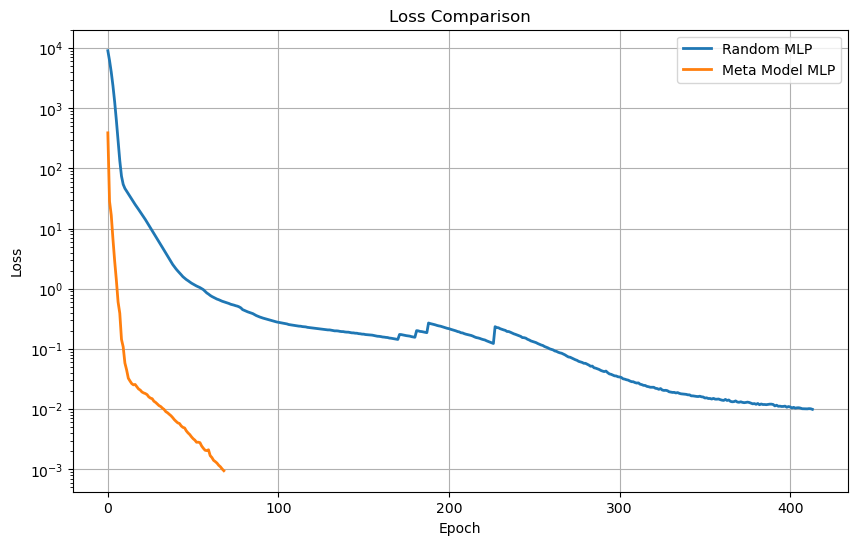

In [21]:
# Training
task_name = 'add_numbers'  # Change to the desired task
random_losses = train_random_mlps(task_name, num_models=5)
meta_losses = train_metamodel_mlp(task_name)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(random_losses, label='Random MLP', linewidth=2)
plt.plot(meta_losses, label='Meta Model MLP', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()